In [1]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
           
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
    
        return out
    
    def __rmul__(self, other): #other*self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward
        
        return out
    
   
        
    def __truediv__(self, other): # self / other
        return self * other**(-1)
    
    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other): #self - other
        return self + -other
    
    def __rsub__(self, other):# other -self
        return other + (-self)
        
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad        
        out._backward = _backward   
        
        return out
        

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [3]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s |data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
# Manual backprop for a neuron
#inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
#weights
w1 = Value(-3.0, label= "w1")
w2 = Value(1.0, label= "w2")
#bias
b = Value(6.8813735870195432, label ="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 +b; n.label = 'n'
#output
o = n.tanh(); o.label = 'o'

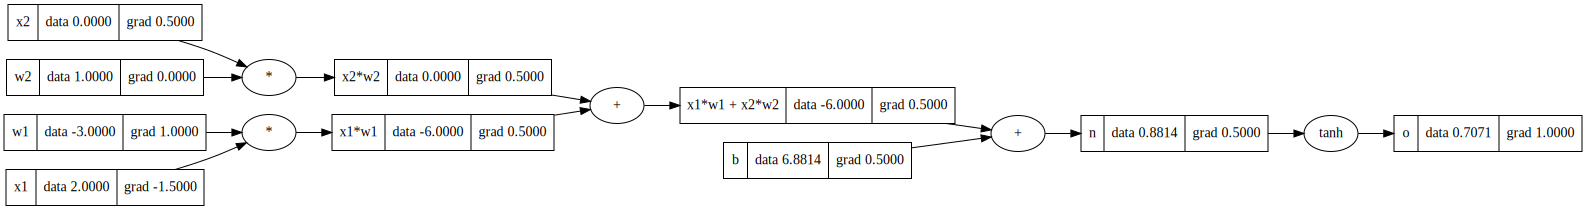

In [8]:
draw_dot(o)

In [7]:
o.backward()

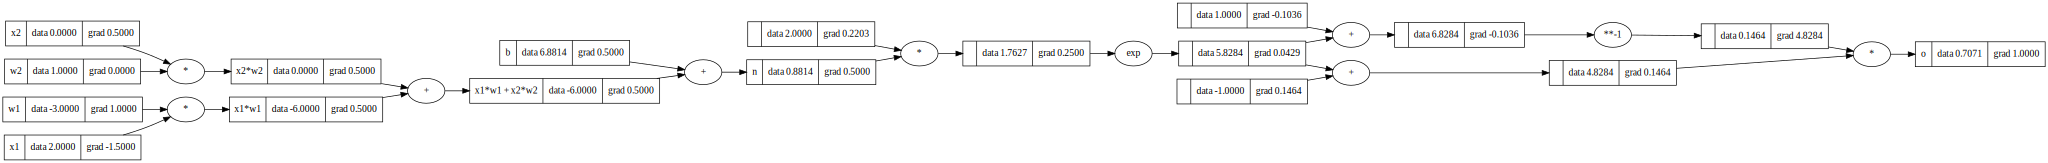

In [35]:
# Manual backprop for a neuron
#inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
#weights
w1 = Value(-3.0, label= "w1")
w2 = Value(1.0, label= "w2")
#bias
b = Value(6.8813735870195432, label ="b")
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n= x1w1x2w2 +b; n.label = 'n'

#------
#output
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

In [4]:
import random


class Neuron:
    def __init__(self, nin):
        self.w =  [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
       
        
        
        
        

In [58]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.2954636117401176)

In [59]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

# ypred = [n(x) for x in xs]

# ypred


In [60]:
for k in range(20):
    #forward prop
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))

    #backprop
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.07 * p.grad
    
    print(k, loss.data)

0 4.25918893688305
1 2.964498981470272
2 3.9922843025113393
3 1.0105508761778659
4 0.2227399353783249
5 0.1022745940555741
6 0.07023285839928976
7 0.0542563742804075
8 0.04454185483190274
9 0.03796635721417025
10 0.03319953169774667
11 0.029573695696407512
12 0.02671550762118184
13 0.024399392101357973
14 0.022480822738751356
15 0.02086282966216251
16 0.019477875341472356
17 0.01827744416312188
18 0.017225764630637776
19 0.01629586707085617


In [61]:
ypred

[Value(data=0.9087731540215569),
 Value(data=-0.975306290241572),
 Value(data=-0.9508343870039193),
 Value(data=0.9296686923143915)]